In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/README
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/metadata.csv
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ004-0143.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ013-0153.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ008-0282.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ048-0113.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ009-0166.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ038-0035.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ031-0043.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ038-0120.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ011-0258.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ028-0409.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ050-0125.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ028-0062.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/

In [2]:
pip install jiwer ## For word error rate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

2024-04-23 01:59:48.646401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 01:59:48.646545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 01:59:48.762939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
wavs_path = "/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/"
metadata_path = "/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/metadata.csv"

In [5]:
metadata_df = pd.read_csv(metadata_path, sep = "|", header = None, quoting=3)
metadata_df.head()

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [6]:
metadata_df.columns = ["File_name","Transcription","Normalized_Transcription"]
metadata_df = metadata_df[["File_name","Normalized_Transcription"]] ##Noramlized trascript Mr.=Mister
metadata_df = metadata_df.sample(frac=0.65).reset_index(drop=True)
metadata_df.head()

,File_name,Normalized_Transcription
0,LJ032-0121,He applied fingerprint powder to the side of t...
1,LJ002-0051,A high wall fifteen feet in height divided the...
2,LJ032-0163,Stombaugh explained in his testimony that in f...
3,LJ038-0036,As McDonald started to search Oswald's waist f...
4,LJ041-0014,"Two days later, quote, some big guy, probably ..."


In [7]:
split = int(len(metadata_df)*0.75)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Training samples : {len(df_train)}")
print(f"Testing samples : {len(df_val)}")

Training samples : 6386
Testing samples : 2129


In [8]:
##Preprocessing 
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token ="",invert=True)

##Array mapping for each characters in vocabulary

print(f"The vocabulary is : {char_to_num.get_vocabulary()}")
print(f"Size : {char_to_num.vocabulary_size()}")

The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' ']
Size : 31


In [9]:
frame_length = 256
frame_step = 100
fft_length = 384

def encode_single_sample(wav_file,label):
    file = tf.io.read_file(wavs_path+wav_file+".wav")
    audio,_ = tf.audio.decode_wav(file) ##converts wav signal data into float tensors
    audio = tf.squeeze(audio,axis=1) ## One dimensional array
    audio = tf.cast(audio,tf.float32) ## Convert data into float32 

    ##short time fourier transform
    spectrogram = tf.signal.stft(
        audio,frame_length=frame_length, frame_step=frame_step,fft_length=fft_length
    )

    spectrogram = tf.abs(spectrogram)  ##Original signal is complex (a+bj) absolute gives (a**2+b**2)
    spectrogram = tf.math.pow(spectrogram,0.5) ## gives magnitude

    ##Normalization
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True) ## everything divided by max value
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)## same as last line
    spectrogram = (spectrogram-means) / (stddevs + 1e-10)

    ##Process the label
    label = tf.strings.lower(label)
    ##split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")

    label = char_to_num(label)
    return spectrogram, label 

In [10]:
##creating dataset objects
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["File_name"]), list(df_train["Normalized_Transcription"]))
)

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["File_name"]), list(df_val["Normalized_Transcription"]))
)

validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

(<tf.Tensor: shape=(32, 2216, 193), dtype=float32, numpy=
array([[[ 0.04026488,  0.43853444,  0.89471036, ..., -1.0223346 ,
         -1.0641766 , -1.1037022 ],
        [ 0.1207601 ,  0.33431485,  0.420915  , ..., -0.9661516 ,
         -1.0819944 , -1.2172409 ],
        [ 1.939883  ,  2.7175825 ,  3.7010355 , ..., -1.2241982 ,
         -1.2696873 , -1.2412883 ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.294686  ,  2.782536  ,  4.4024568 , ..., -0.81187373,
         -0.9463938 , -0.99960965],
        [ 3.1512003 ,  3.161096  ,  1.8723913 , ..., -1.2544153 ,
         -1.2516279 , -1.2392901 ],
        [ 0.73337406,  2.1832435 ,  2.9755332 , ..., -0.7210515 ,
         -0.7211182 , -0.7292011 ],
        .

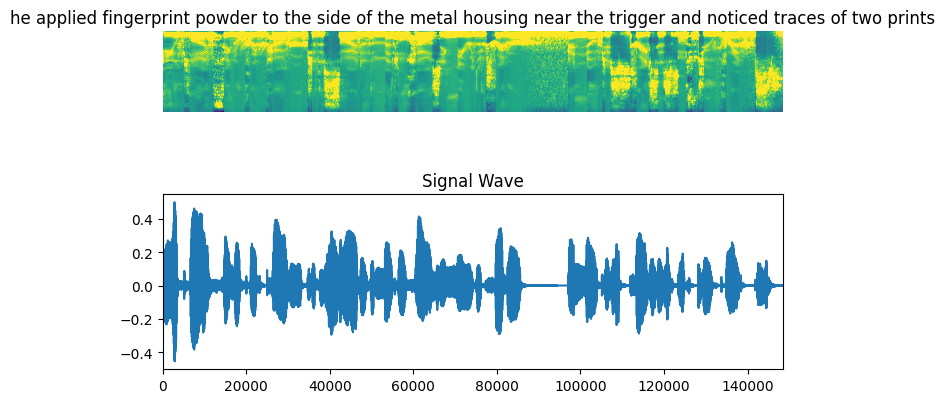

In [11]:
##Vizualize the Dataset
fig = plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
    print(batch)
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    ##Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2,1,1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis('off')
    ##wav file
    file = tf.io.read_file(wavs_path+list(df_train["File_name"])[0]+".wav")
    audio,_ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2,1,2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate = 10000))
plt.show()

In [12]:
##CTC loss is to be used with an RNN netowrk
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")

    input_length = input_length * tf.ones(shape = (batch_len, 1), dtype = "int64")
    label_length = label_length * tf.ones(shape = (batch_len, 1), dtype = "int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [13]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech"""
    ##model's input and expansion to use in 2D CNN
    input_spectrogram = layers.Input((None, input_dim), name = "input")
    x = layers.Reshape((-1, input_dim, 1), name = "expand_dim")(input_spectrogram)
    ##Convolutional Layers
    x = layers.Conv2D(
        filters = 32,
        kernel_size = [11,41],
        strides = [2,2],
        padding = "same",
        use_bias = False,
        name = "conv_1",
    )(x)
    x = layers.BatchNormalization(name = "conv_1_bn")(x)
    x = layers.ReLU(name = "conv_1_relu")(x)

    x = layers.Conv2D(
        filters = 32,
        kernel_size = [11,21],
        strides = [1,2],
        padding = "same",
        use_bias = False,
        name = "conv_2",
    )(x)
    x = layers.BatchNormalization(name = "conv_2_bn")(x)
    x = layers.ReLU(name = "conv_2_relu")(x)
    ##Reshape the resultant volume to feed into RNNs layer
    x = layers.Reshape((-1, x.shape[-2]*x.shape[-1]))(x)
    #RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units = rnn_units,
            activation = "tanh",
            recurrent_activation = "sigmoid",
            use_bias = True,
            return_sequences = True,
            reset_after = True,
            name = f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name = f"Bidirectional_{i}", merge_mode = "concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate = 0.5)(x)
    
    ##Dense layers
    x = layers.Dense(units = rnn_units*2, name = "dense_1")(x)
    x = layers.ReLU(name = "dense_1_relu")(x)
    x = layers.Dropout(rate = 0.5)(x)

    ##Classification Layer
    output = layers.Dense(units = output_dim + 1, activation = "softmax")(x)
    model = keras.Model(input_spectrogram, output, name = "DeepSpeech2")

    optimizer = keras.optimizers.Adam(learning_rate = 1e-4)

    model.compile(optimizer = optimizer, loss = CTCLoss)
    return model

In [14]:
##Get the model
model = build_model(
    input_dim = fft_length//2 + 1,
    output_dim = char_to_num.vocabulary_size(),
    rnn_units = 512,
)

model.summary(line_length=110)

Model: "DeepSpeech2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ Bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ Bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ Bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ Bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,628,480 (101.58 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

In [15]:
##Training and evaluation
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0])*pred.shape[1]

    results = keras.backend.ctc_decode(pred, input_length = input_len, greedy = True)[0][0]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

class CallbackEval(keras.callbacks.Callback):
    ##Displays a batch of output after every epoch
    def __init__(self,dataset):
        super().__init__()
        self.dataset = dataset 
    def on_epoch_end(self, epoch : int, logs = None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X,y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-"*100)
        print(f"Word Error rate : {wer_score:.4f}")
        print("-"*100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target : {targets[i]}")
            print(f"Prediction : {predictions[i]}")
            print("-"*100)

In [16]:
##Training
epochs = 40

validation_callback = CallbackEval(validation_dataset)

history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = epochs,
    callbacks = [validation_callback],
)

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/step - loss: 479.1526
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1

In [18]:
predictions = []     ##testing of model over validation set
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions) ##word error rate
print("-"*100)
print(f"Word Error rate : {wer_score:.4f}")
print("-"*100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target : {targets[i]}")
    print(f"Prediction : {predictions[i]}")
    print("-"*100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste